# Project

## Progress Report 1 - EDA of the UNSW-NB15 Dataset

### 1. Intro
The UNSW-NB15 dataset is a large-scale network intrusion dataset created by the Australian Centre for Cyber Security (ACCS). It contains modern attack types and realistic network traffic generated using the IXIA PerfectStorm tool. The dataset is widely used in cybersecurity research for network intrusion detection and classification tasks.

This project uses the UNSW-NB15 dataset to develop a machine learning model capable of distinguishing malicious network flows from benign ones.

### 2. Dataset Description

#### Source
- Generated by ACCS
- Available on: Australian Cyber Security Centre repo or Kaggle mirrors
- Collected using the IXIA PerfectStorm to simulate diverse network traffic

#### Size
- Four CSV files combined
- Total rows: 2,540,000+
- Total features: 49 attributes
- Label column: `Label` (0 = benign, 1 = attack)
- Attack category column: `attack_cat` with 9 attack categories

#### Features
- Flow-based features (duration, packets, bytes)
- TCP/UDP-specific fields
- Content and time-based metrics
- Statistical connection features
- Categorical attributes (protocol, state, IP, port)

#### What the dataset was used for
- Binary intrusion detection (attack vs. normal)
- Multiclass attack classification
- Feature selection research
- Hybrid/ensemble intrusion models
- Real-time intrusion detection systems (IDS)

### 3. Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
# pd.set_option('max_columns', 200)

first = pd.read_csv('archive/UNSW-NB15_1.csv')
second = pd.read_csv('archive/UNSW-NB15_2.csv')
third = pd.read_csv('archive/UNSW-NB15_3.csv')
fourth = pd.read_csv('archive/UNSW-NB15_4.csv')

unsw_train = pd.read_csv('archive/UNSW_NB15_training-set.csv')
unsw_test = pd.read_csv('archive/UNSW_NB15_testing-set.csv')

all = pd.concat([first, second, third, fourth],
                        ignore_index=True) # concatenate the 4 separated datasets


# separate attack and normal connections
attacks_all = all[all['Label'] == 1].copy()
clear_all = all[all['Label'] == 0].copy()

attacks_train = unsw_train[unsw_train['label'] == 1].copy()
clear_train = unsw_train[unsw_train['label'] == 0].copy()

attacks_test = unsw_test[unsw_test['label'] == 1].copy()
clear_test = unsw_test[unsw_test['label'] == 0].copy()

C:\Users\fouzi\AppData\Local\Temp\ipykernel_65000\1011016854.py:8: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv('archive/UNSW-NB15_1.csv')
C:\Users\fouzi\AppData\Local\Temp\ipykernel_65000\1011016854.py:9: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  second = pd.read_csv('archive/UNSW-NB15_2.csv')


#### 3.1 Class Imbalance

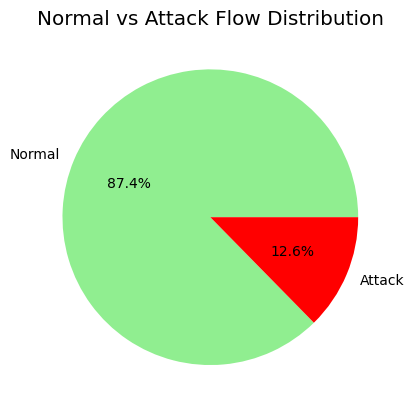

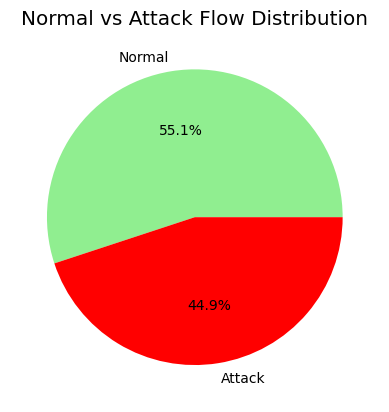

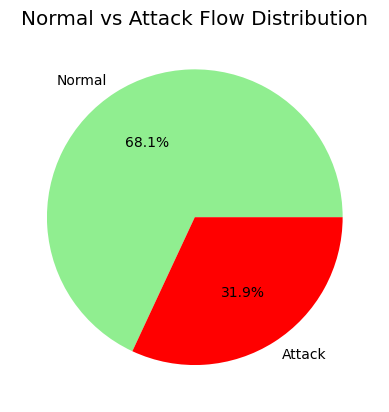

In [2]:
all['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'red'], labels=['Normal','Attack'])
plt.title("Normal vs Attack Flow Distribution")
plt.ylabel("")
plt.show()

unsw_train['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'red'], labels=['Normal','Attack'])
plt.title("Normal vs Attack Flow Distribution")
plt.ylabel("")
plt.show()

unsw_test['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'red'], labels=['Normal','Attack'])
plt.title("Normal vs Attack Flow Distribution")
plt.ylabel("")
plt.show()

A pie chart of the `Label` column shows that for the training dataset:
- Normal: 55.1%
- Attack: 44.9%

and for the testing dataset:
- Normal: 68.1%
- Attack: 31.9%

The balance is better on the training set than the 4 combined datasets, so safe to say our model training will not face many issues.

#### 3.2 Feature Behavior: Normal vs. Attack

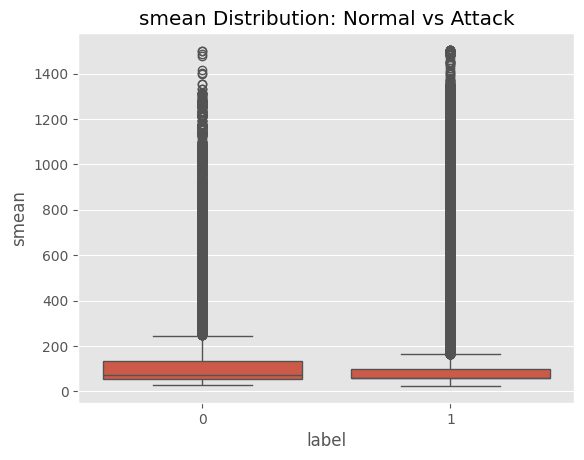

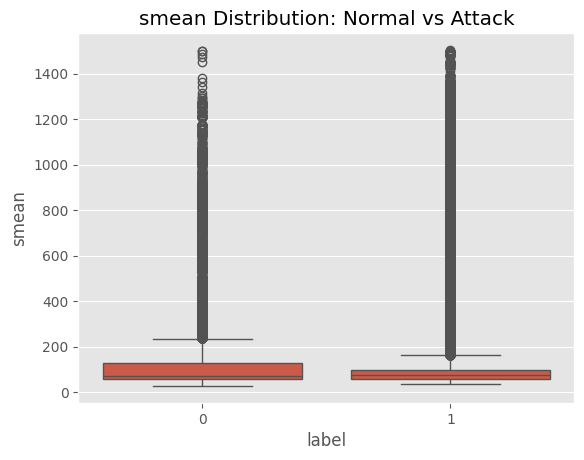

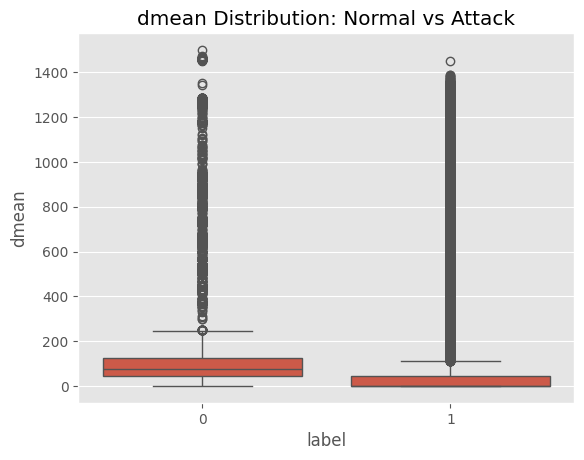

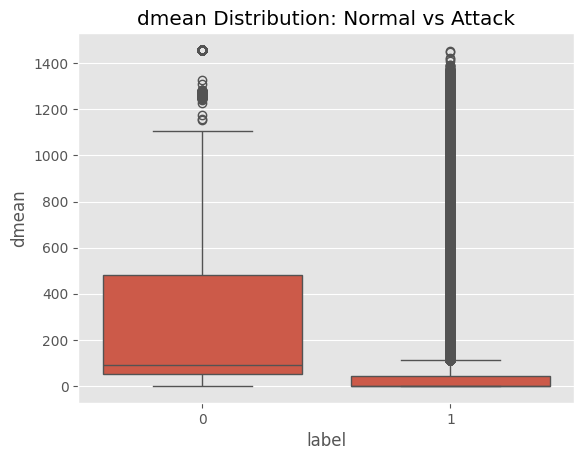

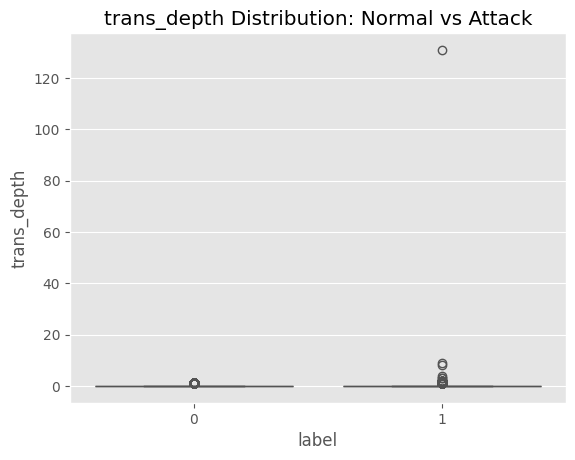

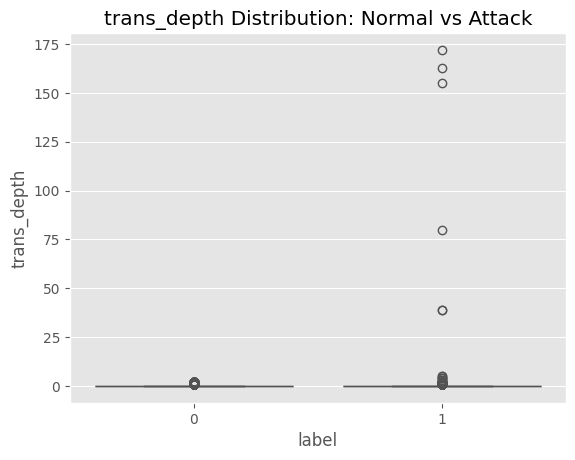

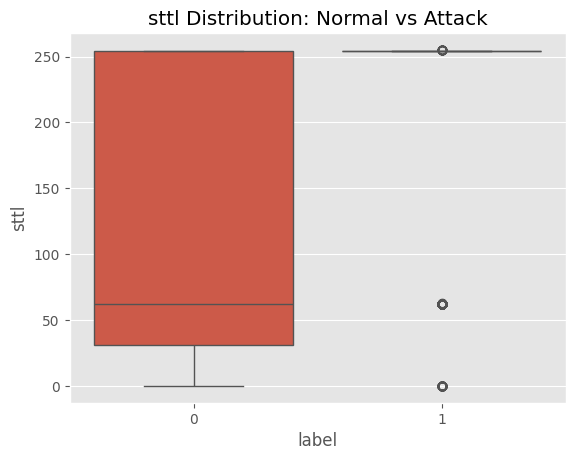

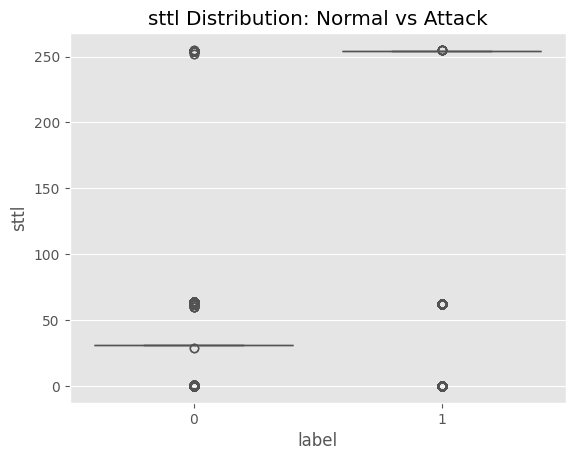

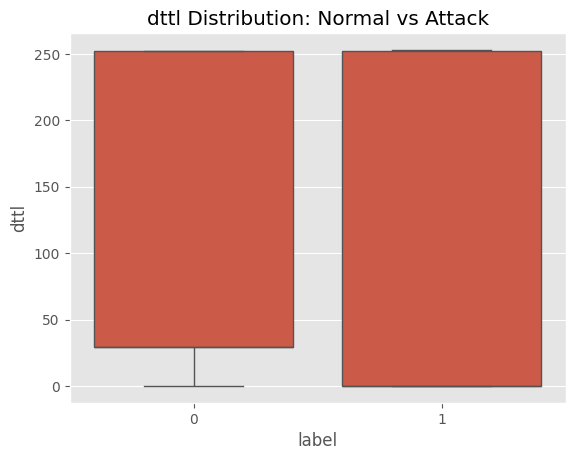

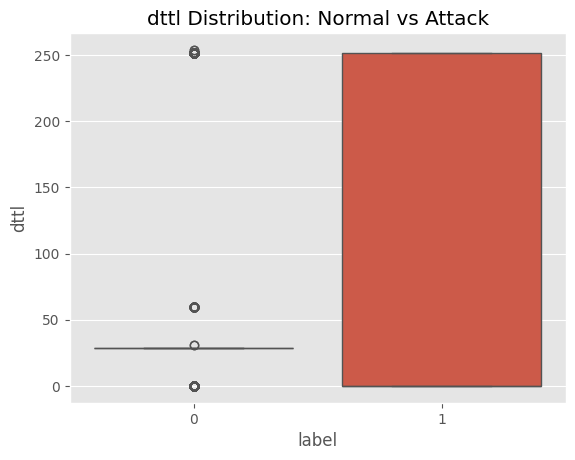

In [3]:
features = ['smean', 'dmean', 'trans_depth', 'sttl', 'dttl']
for f in features:
    sns.boxplot(x='label', y=f, data=unsw_train)
    plt.title(f"{f} Distribution: Normal vs Attack")
    plt.show()
    sns.boxplot(x='label', y=f, data=unsw_test)
    plt.title(f"{f} Distribution: Normal vs Attack")
    plt.show()

Boxplots for selected continuous features (`smean`, `dmean`, `trans_depth`, `sttl`):
- Attack flows tend to have higher TTL values, artificially maxing it out at sttl = 254\
- Some features show significant skew and heavy tails
- Many features have different distributions across attack vs. normal, meaning they are useful for classification

#### 3.3 Attack Category Analysis

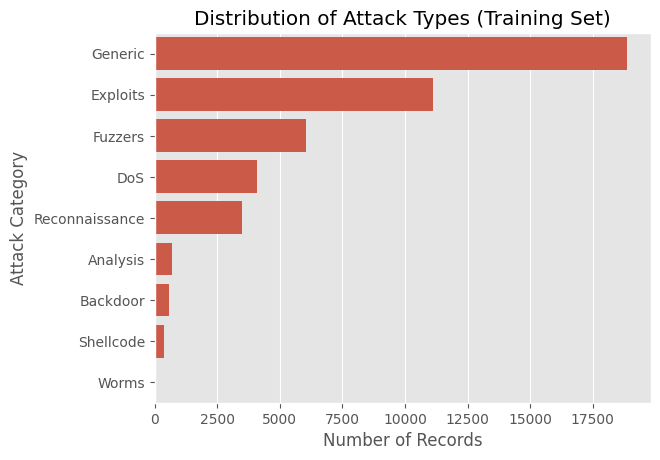

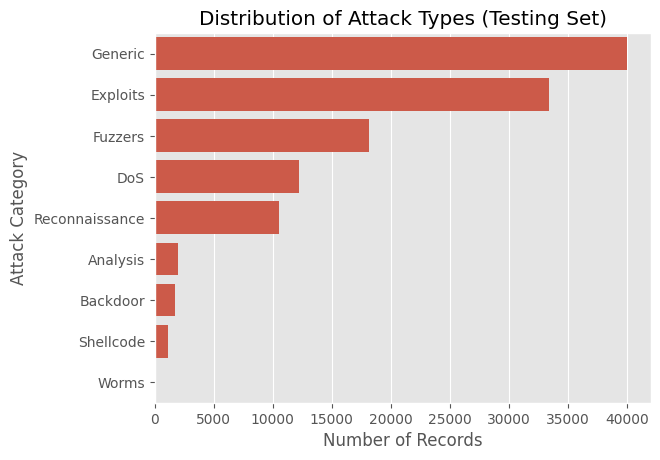

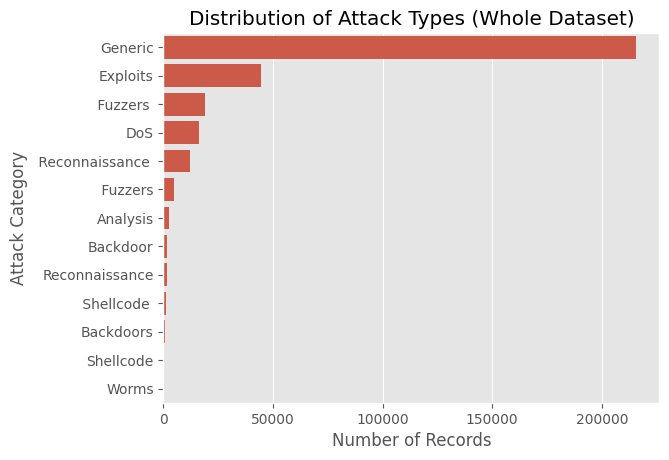

In [4]:
sns.countplot(y='attack_cat', data=attacks_train, order=attacks_train['attack_cat'].value_counts().index)
plt.title("Distribution of Attack Types (Training Set)")
plt.xlabel("Number of Records")
plt.ylabel("Attack Category")
plt.show()

sns.countplot(y='attack_cat', data=attacks_test, order=attacks_test['attack_cat'].value_counts().index)
plt.title("Distribution of Attack Types (Testing Set)")
plt.xlabel("Number of Records")
plt.ylabel("Attack Category")
plt.show()

sns.countplot(y='attack_cat', data=attacks_all, order=attacks_all['attack_cat'].value_counts().index)
plt.title("Distribution of Attack Types (Whole Dataset)")
plt.xlabel("Number of Records")
plt.ylabel("Attack Category")
plt.show()

After cleaning the attack category labels:
- Top attack types
    - Generic (the largest)
    - Exploits
    - Fuzzers
- Rarest categories: Worms, Shellcode

Distribution plots confirm an imbalance between attack types.

#### 3.4 Key Findings
- Dataset is large-scale and highly imbalanced
- Certain features (like TTL) show clear separability between attack and normal flows
- Attack categories vary greatly in frequency

---

## Progress Report 2 - Predictive Model Implementation

### Introduction
- We want to design a predictive model for binary intrusion detection using the UNSW-NB15 dataset. We have to make the implementation from scratch.

### Scratch Model Chosen
- We decided to go with a Decision Tree Classifier, specifically the CART algorithm that uses Gini Index

### Actual Scratch Model (Homemade Decision Tree Classifier):

In [3]:
import numpy as np

class DecisionTreeScratch:
    def __init__(self, max_depth=5, min_samples_split=2, max_features="sqrt"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    # ---------------- FIT ---------------- #

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset, depth=0)

    # --------------- BUILD TREE --------------- #

    def _build_tree(self, dataset, depth):
        X = dataset[:, :-1]
        y = dataset[:, -1]

        num_samples, num_features = X.shape

        # 1. Pure node → leaf
        if len(np.unique(y)) == 1:
            return self.Node(value=y[0])

        # 2. Stop conditions
        if depth >= self.max_depth or num_samples < self.min_samples_split:
            return self.Node(value=self._majority_class(y))

        # 3. Find best split
        best_feature, best_thresh = self._best_split(X, y)

        # No valid split found
        if best_feature is None:
            return self.Node(value=self._majority_class(y))

        # 4. Split dataset
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # Prevent infinite recursion
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return self.Node(value=self._majority_class(y))

        left_data = dataset[left_idxs]
        right_data = dataset[right_idxs]

        left_child = self._build_tree(left_data, depth + 1)
        right_child = self._build_tree(right_data, depth + 1)

        return self.Node(
            feature_index=best_feature,
            threshold=best_thresh,
            left=left_child,
            right=right_child
        )

    # --------------- SPLITTING UTILS --------------- #

    def _split(self, feature_column, threshold):
        left_idxs = np.where(feature_column <= threshold)[0]
        right_idxs = np.where(feature_column > threshold)[0]
        return left_idxs, right_idxs

    # --------------- GINI --------------- #

    def _gini(self, y):
        counts = np.bincount(y.astype(int))
        p = counts[counts > 0] / len(y)
        return 1 - np.dot(p, p)


    # --------------- BEST SPLIT --------------- #

    def _best_split(self, X, y):
        num_samples, num_features = X.shape
        best_feature, best_thresh = None, None
        best_gini = 1.0

        if self.max_features == "sqrt":
            feature_indices = np.random.choice(num_features, int(np.sqrt(num_features)), replace=False)
        elif self.max_features == "log2":
            feature_indices = np.random.choice(num_features, int(np.log2(num_features)), replace=False)
        elif isinstance(self.max_features, int):
            feature_indices = np.random.choice(num_features, self.max_features, replace=False)
        else:
            feature_indices = range(num_features)

        for feature_index in feature_indices:

            feature_values = X[:, feature_index]

            # Sort feature values & labels together
            sorted_idx = np.argsort(feature_values)
            sorted_x = feature_values[sorted_idx]
            sorted_y = y[sorted_idx]

            # Try split points only at label changes
            for i in range(1, num_samples):

                # Skip if identical values (can't split)
                if sorted_x[i] == sorted_x[i - 1]:
                    continue

                # Only consider splits where label changes
                if sorted_y[i] == sorted_y[i - 1]:
                    continue

                # Threshold between adjacent values
                threshold = (sorted_x[i] + sorted_x[i - 1]) / 2

                left_idx = sorted_idx[:i]
                right_idx = sorted_idx[i:]

                gini_left = self._gini(y[left_idx])
                gini_right = self._gini(y[right_idx])

                weighted_gini = (
                    len(left_idx) * gini_left +
                    len(right_idx) * gini_right
                ) / num_samples

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_index
                    best_thresh = threshold


        return best_feature, best_thresh

    # --------------- MAJORITY CLASS --------------- #

    def _majority_class(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    # --------------- PREDICTION --------------- #

    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
    
        indent = "  " * depth
    
        # Leaf node
        if node.value is not None:
            print(f"{indent}Leaf: Predict = {node.value}")
            return
    
        # Decision node
        print(f"{indent}Feature[{node.feature_index}] <= {node.threshold:.4f}?")
        print(f"{indent}--> True:")
        self.print_tree(node.left, depth + 1)
        print(f"{indent}--> False:")
        self.print_tree(node.right, depth + 1)



## Preprocessing Pipeline

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

# 1. KEEP TRAIN AND TEST SEPARATE
# Assuming unsw_train and unsw_test are already loaded DataFrames
df_train = unsw_train.copy()
df_test = unsw_test.copy()

# Define columns
categorical_cols = ['proto', 'service', 'state']
label_col = 'label'

# Clean drop columns (apply to BOTH)
drop_cols = ['id', 'attack_cat']
df_train = df_train.drop(columns=drop_cols, errors='ignore')
df_test = df_test.drop(columns=drop_cols, errors='ignore')

# 2. FIX RARE CATEGORIES (Fit on Train, Apply to Test)
for col in categorical_cols:
    # 2.1. Calculate counts ONLY on training data
    counts = df_train[col].value_counts()
    
    # 2.2. Define the "Allowed" list (common categories)
    allowed_vals = counts[counts >= 20].index.tolist()
    
    # 2.3. Replace rare values in TRAIN
    df_train.loc[~df_train[col].isin(allowed_vals), col] = "RARE_CAT"
    
    # 2.4. Replace values in TEST that are not in the TRAIN allowed list
    # (This handles both rare values AND values unseen during training)
    df_test.loc[~df_test[col].isin(allowed_vals), col] = "RARE_CAT"

# 3. CORRELATION FILTERING (Fit on Train, Apply to Test)
# Identify numeric columns
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

# 3.1. Calculate Correlation Matrix ONLY on Train
corr = df_train[numeric_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3.2. Find columns to drop
corr_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

# 3.3. Drop from BOTH
df_train = df_train.drop(columns=corr_drop)
df_test = df_test.drop(columns=corr_drop)

# Update numeric_cols list after dropping
numeric_cols = [c for c in numeric_cols if c not in corr_drop]

print(f"Dropped {len(corr_drop)} correlated features based on Training data stats.")

# 4. ONE-HOT ENCODING (Fit on Train, Apply to Test)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on Train
encoded_train_cat = encoder.fit_transform(df_train[categorical_cols])

# Transform Test (using the rules learned from Train)
encoded_test_cat = encoder.transform(df_test[categorical_cols])


# 5. ASSEMBLE FINAL ARRAYS
X_train = np.hstack([df_train[numeric_cols].values, encoded_train_cat])
y_train = df_train[label_col].values

X_test = np.hstack([df_test[numeric_cols].values, encoded_test_cat])
y_test = df_test[label_col].values


# 6. MUTUAL INFORMATION (Fit on Train, Apply to Test)
# Calculate MI scores on Training data
mi = mutual_info_classif(X_train, y_train, random_state=42)

# Select features
mi_threshold = 0.0001 
keep_mask = mi > mi_threshold

# Apply mask to BOTH
X_train = X_train[:, keep_mask]
X_test = X_test[:, keep_mask]

print("\nFinal Shapes:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)

Dropped 8 correlated features based on Training data stats.

Final Shapes:
X_train: (82332, 124)
X_test:  (175341, 124)


### Building and Fitting on the Scratch model

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# 1. Create the tree
tree = DecisionTreeScratch(max_depth=12, min_samples_split=10)

# 2. Train
start = time.time()
tree.fit(X_train, y_train)
end = time.time()

# 3. Predict on test set
start2 = time.time()
y_pred = tree.predict(X_test)
end2 = time.time()

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Scratch Decision Tree Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)
print(f"Training time: {end - start:.4f} seconds")
print(f"Prediction time: {end2 - start2:.4f} seconds")

Scratch Decision Tree Accuracy: 0.8749579391015222
Confusion Matrix:
 [[53801  2199]
 [19726 99615]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83     56000
           1       0.98      0.83      0.90    119341

    accuracy                           0.87    175341
   macro avg       0.86      0.90      0.87    175341
weighted avg       0.90      0.87      0.88    175341

Training time: 12.7913 seconds
Prediction time: 0.2335 seconds


In [9]:
tree.print_tree()

Feature[1] <= 2.5000?
--> True:
  Feature[35] <= 0.5000?
  --> True:
    Feature[2] <= 0.5000?
    --> True:
      Feature[10] <= 34552.5880?
      --> True:
        Feature[58] <= 0.5000?
        --> True:
          Feature[8] <= 0.0535?
          --> True:
            Feature[124] <= 0.5000?
            --> True:
              Leaf: Predict = 0.0
            --> False:
              Feature[8] <= 0.0035?
              --> True:
                Feature[0] <= 0.0000?
                --> True:
                  Leaf: Predict = 1.0
                --> False:
                  Leaf: Predict = 1.0
              --> False:
                Leaf: Predict = 1.0
          --> False:
            Feature[24] <= 19.0000?
            --> True:
              Feature[25] <= 8.5000?
              --> True:
                Leaf: Predict = 1.0
              --> False:
                Leaf: Predict = 0.0
            --> False:
              Leaf: Predict = 0.0
        --> False:
          Leaf: Predict =

## Other Models from Sklearn to compare to our scratch model

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)


clf=grid_search.best_estimator_
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 0.8839270250093726
Accuracy: 0.9082302484872334


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=10,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8925978521851706
[[ 54547   1453]
 [ 17379 101962]]
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     56000
           1       0.99      0.85      0.92    119341

    accuracy                           0.89    175341
   macro avg       0.87      0.91      0.88    175341
weighted avg       0.91      0.89      0.90    175341



In [8]:
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,          # let trees grow deep
    min_samples_split=5,
    n_jobs=-1,               # use all cores
    class_weight='balanced', # handle imbalance
    random_state=42
)

eval_model("Random Forest", rf, X_train, y_train, X_test, y_test)



=== Random Forest ===
Accuracy: 0.9028122344460223
Confusion Matrix:
 [[ 54666   1334]
 [ 15707 103634]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87     56000
           1       0.99      0.87      0.92    119341

    accuracy                           0.90    175341
   macro avg       0.88      0.92      0.89    175341
weighted avg       0.92      0.90      0.91    175341



In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=3,
    random_state=42
)

eval_model("Gradient Boosting", gb, X_train, y_train, X_test, y_test)



=== Gradient Boosting ===
Accuracy: 0.9035251310303922
Confusion Matrix:
 [[ 54623   1377]
 [ 15539 103802]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87     56000
           1       0.99      0.87      0.92    119341

    accuracy                           0.90    175341
   macro avg       0.88      0.92      0.90    175341
weighted avg       0.92      0.90      0.91    175341



In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # again, for imbalance
    n_jobs=-1
)

eval_model("Logistic Regression", logreg, X_train, y_train, X_test, y_test)



=== Logistic Regression ===
Accuracy: 0.716945836969106
Confusion Matrix:
 [[52787  3213]
 [46418 72923]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.94      0.68     56000
           1       0.96      0.61      0.75    119341

    accuracy                           0.72    175341
   macro avg       0.74      0.78      0.71    175341
weighted avg       0.82      0.72      0.73    175341



In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(150, 100),
    activation='relu',
    solver='adam',
    max_iter=1000,         # bump up if it keeps “not converged” warning
    random_state=42
)

eval_model("MLP Neural Network", mlp, X_train, y_train, X_test, y_test)



=== MLP Neural Network ===
Accuracy: 0.7618526186117337
Confusion Matrix:
 [[ 14844  41156]
 [   601 118740]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.27      0.42     56000
           1       0.74      0.99      0.85    119341

    accuracy                           0.76    175341
   macro avg       0.85      0.63      0.63    175341
weighted avg       0.81      0.76      0.71    175341



In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Initialize a list to store results
results_list = []

# 2. Define a function to calculate metrics and add to the list
def evaluate_and_store(model_name, y_true, y_pred):
    # Using 'weighted' average because your dataset is imbalanced
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    results_list.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

# 3. Process the Scratch Decision Tree
# (Assuming 'tree' is your custom class instance)
print("Processing Decision Tree (Scratch)...")
y_pred_scratch = tree.predict(X_test)
evaluate_and_store("Decision Tree (Scratch)", y_test, y_pred_scratch)

# 4. Process Scikit-Learn Models
# List of (Name, Model_Object) tuples based on your variable names
sklearn_models = [
    ("Decision Tree (Sklearn)", clf),
    ("Random Forest", rf),
    ("Gradient Boosting", gb),
    ("Logistic Regression", logreg),
    ("MLP Neural Network", mlp)
]

for name, model in sklearn_models:
    print(f"Processing {name}...")
    y_pred = model.predict(X_test)
    evaluate_and_store(name, y_test, y_pred)

# 5. Create DataFrame
df_results = pd.DataFrame(results_list)

# 6. Display the table in the notebook
print("\nFinal Comparison:")
display(df_results)

# 7. Export to CSV
csv_filename = "model_comparison_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"\nResults successfully exported to {csv_filename}")

Processing Decision Tree (Scratch)...
Processing Decision Tree (Sklearn)...
Processing Random Forest...
Processing Gradient Boosting...
Processing Logistic Regression...
Processing MLP Neural Network...

Final Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree (Scratch),0.874958,0.899616,0.874958,0.878463
1,Decision Tree (Sklearn),0.892598,0.913268,0.892598,0.895444
2,Random Forest,0.902812,0.920066,0.902812,0.905225
3,Gradient Boosting,0.903525,0.920356,0.903525,0.905897
4,Logistic Regression,0.716946,0.821840,0.716946,0.725062
5,MLP Neural Network,0.761853,0.812385,0.761853,0.711555



Results successfully exported to model_comparison_results.csv
